In [25]:
## Imports

# General
import os
import os.path as path
import re
import sys
import json
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from scipy.spatial import distance

# Torchvision
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as tf
from torchvision.io import read_image

# Load local SimSiam model
sys.path.append('/'+path.join(os.getcwd(), '0_pytorch-SimSiam'))
from models.simsiam import SimSiam
from collections import OrderedDict

%matplotlib inline

In [144]:
# Set data to be processed
DROOT = './0_data'

# Database.json
EYE_SRC = path.join(DROOT, "2_procfootage/eyetracker")
RND_SRC = path.join(DROOT, "2_procfootage/round_img")
MAP_DST = path.join(DROOT, "4_simsiam/mapping.csv")

## Load Model

In [17]:
model = SimSiam(backbone='resnet50')
checkpoint = torch.load('0_unsupervised_pretrained.pth.tar', 
                        map_location=torch.device('cpu'))
state_dict_filtered = OrderedDict([(k[7:], v) if 'module.' in k else (k, v) 
                                   for k, v in checkpoint['state_dict'].items()])
model.load_state_dict(state_dict_filtered)

<All keys matched successfully>

## Load 360-footage and frames

In [79]:
class LoadEyeTrackerData(Dataset):
    """Loads data from folder with x, y and frameid in filename."""
    
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        
        images = glob(os.path.join(img_dir, '*.png'))
        self.img_images = sorted(images, key=lambda x: int(re.search('(\d+)\.png', x).group(1)))
        self.img_labels = pd.read_csv(os.path.join(img_dir, 'labels.csv'), index_col='frame')
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = read_image(self.img_images[idx])
        label = self.img_labels.iloc[idx].to_dict()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [100]:
preprocess_base = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((224,224)),
    tf.GaussianBlur(3, sigma=(1,1)),
    tf.ToTensor(),
])

preprocess_frame = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((224,224)),
    tf.GaussianBlur(3, sigma=(1,1)),
    tf.Lambda(lambda img: tf.functional_pil.adjust_brightness(img, 1.1)),
#     tf.Lambda(lambda img: tf.functional_pil.adjust_saturation(img, 2)),
    tf.ToTensor(),
])

dataset_base = LoadEyeTrackerData(RND_SRC, transform=preprocess_base)
loader_base = torch.utils.data.DataLoader(dataset_base, batch_size=100000)

dataset_frame = LoadEyeTrackerData(EYE_SRC, transform=preprocess_frame)
loader_frame = torch.utils.data.DataLoader(dataset_frame, batch_size=100000)

features_base, labels_base = next(iter(loader_base))
features_frame, labels_frame = next(iter(loader_frame))

# Tmpfix
labels_base['y'] += 543

features_frame.shape, features_base.shape

(torch.Size([246, 3, 224, 224]), torch.Size([155, 3, 224, 224]))

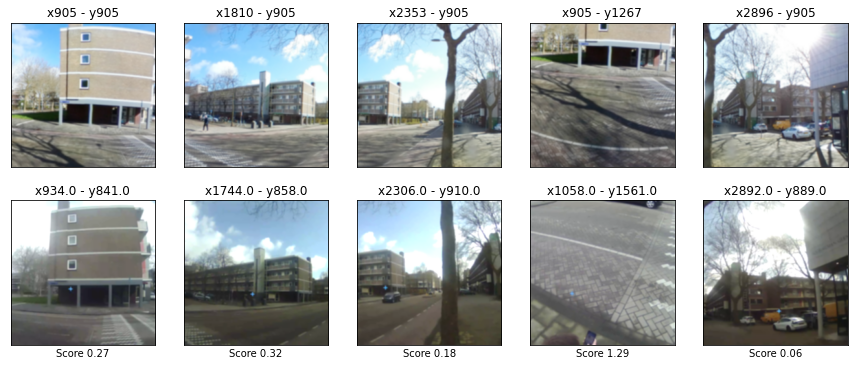

In [106]:
baseidx = [67, 72, 75, 129, 78]
frameidx = [6, 38, 174, 213, 146]

# Get coordinate list of both base and frame
base_coords = list(zip(labels_base['x'][baseidx], labels_base['y'][baseidx]))
frme_coords = list(zip(labels_frame['true_x'][frameidx], labels_frame['true_y'][frameidx]))
zipped = list(zip(base_coords, frme_coords))

# Score amount of frames of difference
max_dist = distance.euclidean((0,0), (181,181))
score = [distance.euclidean(base, frme) / max_dist for base, frme in zipped]

# Plot out
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
for i in range(5):
    
    axs[0][i].imshow(tf.functional.to_pil_image(features_base[baseidx[i]]))
    axs[1][i].imshow(tf.functional.to_pil_image(features_frame[frameidx[i]]))

    axs[0][i].set_title(f"x{labels_base['x'][baseidx[i]]} - y{labels_base['y'][baseidx[i]]}")
    axs[1][i].set_title(f"x{labels_frame['true_x'][frameidx[i]]} - y{labels_frame['true_y'][frameidx[i]]}")
    
    axs[0][i].axes.yaxis.set_ticks([])
    axs[0][i].axes.xaxis.set_ticks([])
    axs[1][i].axes.yaxis.set_ticks([])
    axs[1][i].axes.xaxis.set_ticks([])
    
    axs[1][i].set_xlabel(f"Score {score[i]:.2f}")
    

## Run SimSiam on frames & base image

In [107]:
# Here, z is the encoder only, and p is the projection. We need both.
with torch.no_grad():
    z_base, p_base = model(features_base)
    z_frame, p_frame = model(features_frame)
    
z_base = z_base.detach().numpy()
p_base = p_base.detach().numpy()
z_frame = z_frame.detach().numpy()
p_frame = p_frame.detach().numpy()

print(z_frame.shape, p_frame.shape)
print(z_base.shape, p_base.shape)

(246, 2048) (246, 2048)
(155, 2048) (155, 2048)


In [130]:
# Find similarities between frame to base image
similarities = [
    [distance.cosine(p_frame[frameid], pix) for pix in p_base]
    for frameid in range(len(labels_frame['true_x']))
]
best_guess = [np.where(s == np.amin(s))[0][0] for s in similarities]

In [146]:
mapping = pd.DataFrame(zip(range(len(labels_frame['true_x'])), best_guess),
                       columns=['eye_frameid', 'rnd_frameid']).set_index('eye_frameid')
mapping.to_csv(MAP_DST)
mapping.tail()

,rnd_frameid
eye_frameid,
241,124
242,124
243,124
244,102
245,123


<AxesSubplot:title={'center':'Closest SimSiam match'}, xlabel='Frameid', ylabel='Times guessed'>

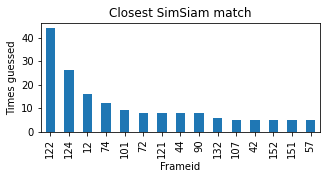

In [159]:
fig, ax = plt.subplots(figsize=(5,2))
ax.set_title("Closest SimSiam match")
ax.set_ylabel("Times guessed")
ax.set_xlabel("Frameid")
mapping.rnd_frameid.value_counts()[:15].plot(kind='bar', ax=ax)

## Find accuracy

In [131]:
# Find accuracy
y = [(labels_base['x'][i], labels_base['y'][i]) for i in best_guess]
z = [(labels_frame['true_x'][i], labels_frame['true_y'][i]) for i in range(len(labels_frame['true_y']))]

# Get scoring mechanism
max_dist = distance.euclidean((0,0), (181,181))

score = np.array([distance.euclidean(y,z) / max_dist for y,z in zip(y,z)])

In [132]:
(score < 2.5).sum() / score.size

0.4268292682926829

### Sample

(array([97., 46., 13., 11., 34., 25., 11.,  2.,  4.,  3.]),
 array([ 0.1000595 ,  2.11773778,  4.13541605,  6.15309432,  8.1707726 ,
        10.18845087, 12.20612915, 14.22380742, 16.24148569, 18.25916397,
        20.27684224]),
 <BarContainer object of 10 artists>)

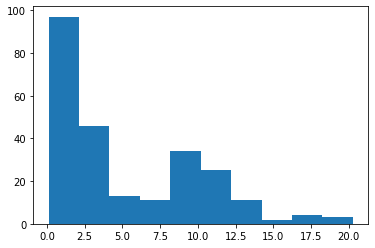

In [133]:
plt.hist(score)

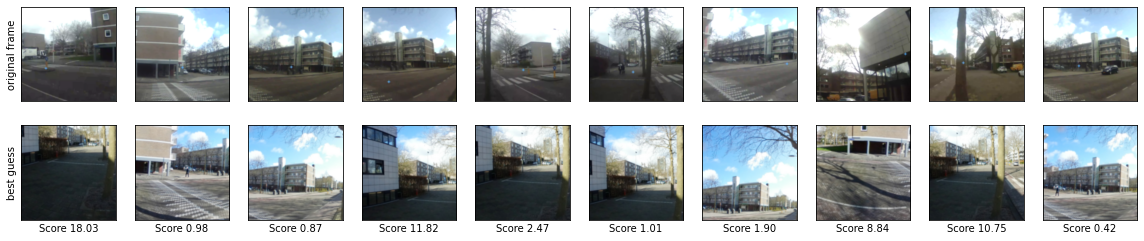

In [147]:
fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(20, 4))

frameids = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]
frame_scores = score[frameids]

axs[1][0].set_ylabel('best guess')
axs[0][0].set_ylabel('original frame')

for i in range(10):
    axs[0][i].axes.xaxis.set_ticks([])
    axs[0][i].axes.yaxis.set_ticks([])
    axs[1][i].axes.xaxis.set_ticks([])
    axs[1][i].axes.yaxis.set_ticks([])
    axs[1][i].set_xlabel(f"Score {frame_scores[i]:.2f}")
    
    axs[0][i].imshow(tf.functional.to_pil_image(features_frame[frameids[i]]))
    axs[1][i].imshow(tf.functional.to_pil_image(features_base[best_guess[frameids[i]]]))